# Brent-WTI Spread Analysis

Investigate the spread between Brent and WTI. Can it be used for pair trading?
Import packages and the raw data. The data is daily granularity stored in OHLC format.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR

import GeneralFunctions_1 as gf #custom scripts only used to import data

df_wti = gf.import_market_data_access('USDCL')
df_brent = gf.import_market_data_access('USDCO')

df_wti.tail()

,Open,High,Low,Close,lastTradedVolume
DateTime,,,,,
2021-05-23 05:00:00,6377.8,6417.7,6359.9,6396.3,25293
2021-05-24 05:00:00,6395.9,6623.2,6383.3,6608.3,355780
2021-05-25 05:00:00,6607.3,6644.9,6535.1,6580.7,401068
2021-05-26 05:00:00,6581.7,6636.4,6519.2,6578.2,315284
2021-05-27 05:00:00,6578.3,6737.1,6540.3,6712.7,290294


Isolate the closing prices and calculate the spread between the prices.

In [2]:
df_brent.rename(columns={"Close": "brent"}, inplace=True)
df_wti.rename(columns={"Close": "wti"}, inplace=True)

In [3]:
df = pd.merge(df_brent['brent'], df_wti['wti'], how='inner', left_index=True, right_index=True)
#df = df.loc['2018':] #cut the data
df['spread'] = df['brent'] - df['wti']
df.tail()

,brent,wti,spread
DateTime,,,
2021-05-23 05:00:00,6679.9,6396.3,283.6
2021-05-24 05:00:00,6853.6,6608.3,245.3
2021-05-25 05:00:00,6833.0,6580.7,252.3
2021-05-26 05:00:00,6831.8,6578.2,253.6
2021-05-27 05:00:00,6947.6,6712.7,234.9


Plot the raw timeseries for WTI and Brent. They move together and the spread looks fairly steady.
However, a plot of the spread dosent look as promising. At this stage, a mean reversion strategy dosent look great.

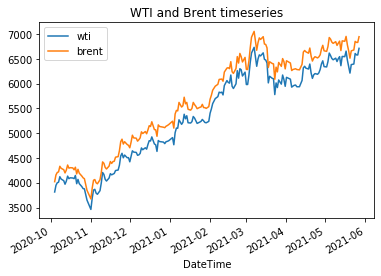

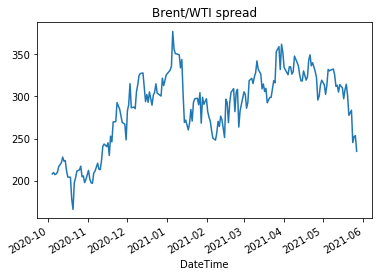

In [4]:
df[['wti','brent']][-200:].plot(title='WTI and Brent timeseries')
plt.show()
df['spread'][-200:].plot(title='Brent/WTI spread')

Calculate the Z score of the spread and plot. This looks more promising.

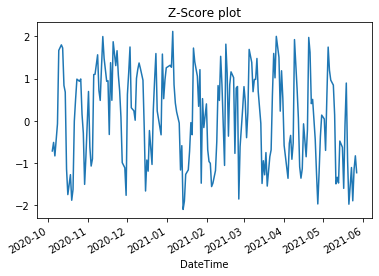

In [5]:
def zscore_calc(df, window=14):
    roll = df.rolling(window)
    out = (df - roll.mean()) / roll.std()
    return out

df['z_score'] = zscore_calc(df['spread'], 7)
df.dropna(inplace=True)
df['z_score'][-200:].plot(title='Z-Score plot')
#plt.show()

### Backtest a simple strategy using the Z score.
From the graph above, we can see that the z score is range bound between +2 and -2. Lets trigger a short position when the score is >1.75 and a long position when it is <-1.75. The position will be held until the signal changes direction.

In [6]:
def add_positions_based_on_z_score(df, long, short):
    df['position'] = np.NaN #set the default position to zero/flat
    df['position'] = df[['z_score','position']].apply(lambda x: 1 if x['z_score']<long else x['position'], axis=1)  #go long if z-score > -1.75
    df['position'] = df[['z_score','position']].apply(lambda x: -1 if x['z_score']>short else x['position'], axis=1)  #go short if z-score > 1.75
    df.ffill(inplace=True) #forward fill, so we always have a position.
    df['position'] = df['position'].shift(1) #avoid look ahead bias. We take a position the next day.
    return df['position']

df['position'] = add_positions_based_on_z_score(df, long=-1.75, short=1.75)
df.dropna(inplace=True)
df.tail(10)

,brent,wti,spread,z_score,position
DateTime,,,,,
2021-05-17 05:00:00,6953.7,6656.5,297.2,-1.597631,1.0
2021-05-18 05:00:00,6782.4,6474.4,308.0,-0.099172,1.0
2021-05-19 05:00:00,6662.3,6347.8,314.5,0.894228,1.0
2021-05-20 05:00:00,6514.2,6213.1,301.1,-0.939515,1.0
2021-05-21 05:00:00,6662.2,6384.6,277.6,-1.972239,1.0
2021-05-23 05:00:00,6679.9,6396.3,283.6,-1.104413,1.0
2021-05-24 05:00:00,6853.6,6608.3,245.3,-1.892130,1.0
2021-05-25 05:00:00,6833.0,6580.7,252.3,-1.149199,1.0
2021-05-26 05:00:00,6831.8,6578.2,253.6,-0.827387,1.0


Generate the strategy returns and pass to pyfolio for analysis.

In [7]:
def generate_strategy_returns(df_prices, df_position):
    #take a df of closing prices and positions. Generate returns.
    df_rtns = df_prices.pct_change()
    df_rtns = df_rtns.merge(df_position, left_index=True, right_index=True)
    df_rtns.columns = ['price_rtn','position']
    df_rtns['strategy_rtn'] = df_rtns['price_rtn'] * df_rtns['position']
    df_rtns.dropna(inplace=True)
    return df_rtns

def generate_spread_strategy_returns(df_spread, df_position):
    #take a df of spread and positions. Returns result in units of spread.
    df_rtns = df_spread.diff()
    df_rtns = df_rtns.merge(df_position, left_index=True, right_index=True)
    df_rtns.columns = ['price_rtn','position']
    df_rtns['strategy_rtn'] = df_rtns['price_rtn'] * df_rtns['position']
    df_rtns.dropna(inplace=True)
    return df_rtns

#gf.export_data(df)
strat_rtns_zscore_diff = generate_spread_strategy_returns(df[['spread']], df[['position']])
strat_rtns_zscore_diff.tail(10)

,price_rtn,position,strategy_rtn
DateTime,,,
2021-05-17 05:00:00,-13.0,1.0,-13.0
2021-05-18 05:00:00,10.8,1.0,10.8
2021-05-19 05:00:00,6.5,1.0,6.5
2021-05-20 05:00:00,-13.4,1.0,-13.4
2021-05-21 05:00:00,-23.5,1.0,-23.5
2021-05-23 05:00:00,6.0,1.0,6.0
2021-05-24 05:00:00,-38.3,1.0,-38.3
2021-05-25 05:00:00,7.0,1.0,7.0
2021-05-26 05:00:00,1.3,1.0,1.3


The simple backtest looks promising, but does calculate incorrect PnL on days when the position changes direction.

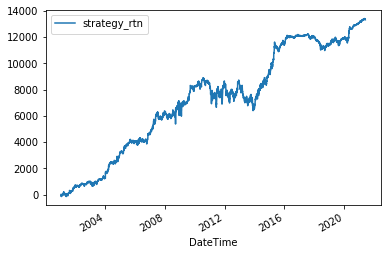

In [8]:
strat_rtns_zscore_diff[['strategy_rtn']].cumsum().plot()

### Can the strategy be improved using co-integration? 
Lets check if the timeseries are stationary.

In [9]:
def adf_test(x):
    #adfuller stationary test
    adf = adfuller(x=x)
    print(x.name)
    print(adf)
    if adf[0] <= adf[4]['1%']:
        print('Timeseries is stationary at 1%.')
    else:
        print('Timeseries has unit root and is NOT stationary at 1%.')

adf_test(df['brent']) 
adf_test(df['wti'])
adf_test(df['spread'])

brent
(-1.977578858614925, 0.29648967975010365, 4, 5437, {'1%': -3.4315533088194674, '5%': -2.8620717417864197, '10%': -2.567053045180285}, 68205.88580031984)
Timeseries has unit root and is NOT stationary at 1%.
wti
(-2.2944351441694812, 0.17376903025883988, 12, 5429, {'1%': -3.4315550828161374, '5%': -2.86207252555614, '10%': -2.5670534624068004}, 68738.25971536894)
Timeseries has unit root and is NOT stationary at 1%.
spread
(-2.780440870437927, 0.06112242188874543, 30, 5411, {'1%': -3.4315590934969875, '5%': -2.8620742975138924, '10%': -2.5670544056787477}, 59928.43797393962)
Timeseries has unit root and is NOT stationary at 1%.


The test shows that we cannot reject the hypothesis that Brent, WTI or the spread are non-stationary.

### Apply the Johansen test to test for co integration.

C:\Users\James\miniconda3\envs\dev_clean\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Test Statistic
[19.17169529  5.45574297]
Significance Levels
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Johansen Test Beta:
[ 1.         -1.21908681]


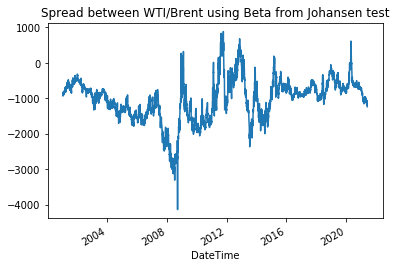

In [10]:
def johansen_test(x1, x2, det_order=0, k_ar_diff=1):
    #apply test to two assets.
    X = pd.concat([x1, x2], axis=1)
    X = X.dropna()            
    jres = coint_johansen(X, det_order, k_ar_diff)
            
    trstat = jres.lr1           # trace statistic
    tsignf = jres.cvt           # critical values
    lr2 = jres.lr2              # Maximum eigenvalue statistic
    max_eigenvalue = jres.eig   # Eigenvalues of VECM coefficient matrix
    #print(jres.trace_stat)
    #print(jres.trace_stat_crit_vals)
    #print(jres.evec)            # Eigenvectors of VECM coefficient matrix
    
    print('Test Statistic')
    print(trstat)
    print('Significance Levels')
    print(tsignf)
    #print(jres.__dict__)
    return [jres.evec[0][0], jres.evec[1][0]]

#find the lag
var = VAR(df[['brent','wti']])
lags = var.select_order()
k_ar_diff = lags.selected_orders['aic']
          
beta = johansen_test(df['brent'], df['wti'], det_order=0, k_ar_diff=k_ar_diff)
beta = beta/beta[0] #normalise to first element

print('Johansen Test Beta:')
print(beta)

df['johansen_spread'] = beta[0] * df['brent'] + beta[1] * df['wti']
df['johansen_spread'].plot(title='Spread between WTI/Brent using Beta from Johansen test')

In [11]:
adf_test(df['johansen_spread'])

johansen_spread
(-3.6310231632721117, 0.005194890080596961, 30, 5411, {'1%': -3.4315590934969875, '5%': -2.8620742975138924, '10%': -2.5670544056787477}, 62368.999661849324)
Timeseries is stationary at 1%.


Run a quick backtest using the z-score of the johansen spread. Same parameters as the previous backtest.

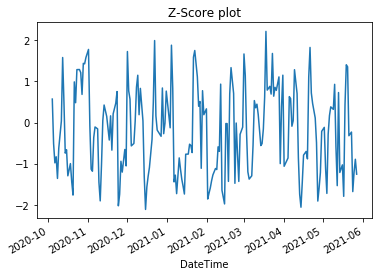

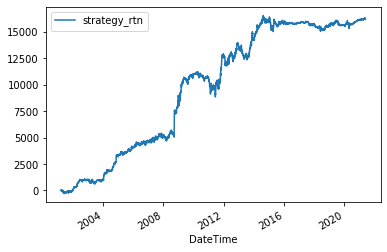

In [12]:
df['z_score'] = zscore_calc(df['johansen_spread'], 7)
df.dropna(inplace=True)
df['z_score'][-200:].plot(title='Z-Score plot')
df['position'] = add_positions_based_on_z_score(df, long=-1.75, short=1.75)
strat_rtns_zscore_jt = generate_spread_strategy_returns(df[['spread']], df[['position']])
strat_rtns_zscore_jt[['strategy_rtn']].cumsum().plot()

Performance looks pretty decent.... until 2014.